# Pima Indians Diabetes Database
> Predict the onset of diabetes based on diagnostic measures

**Context:**
- This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**Content**
- The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

- [Link to the dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data)

In [3]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

In [2]:
df = pd.read_csv("pima_data.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
df['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


In [9]:
# zero values check (important for this dataset)
zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
(df[zero_cols] == 0).sum()

,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


<Axes: xlabel='Outcome', ylabel='count'>

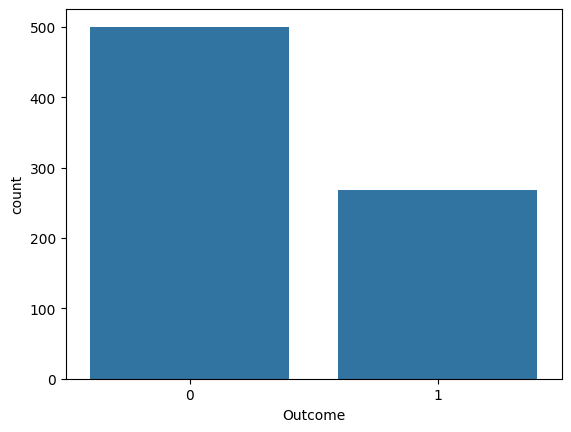

In [12]:
# target distribution
sns.countplot(data=df, x='Outcome')

<Axes: >

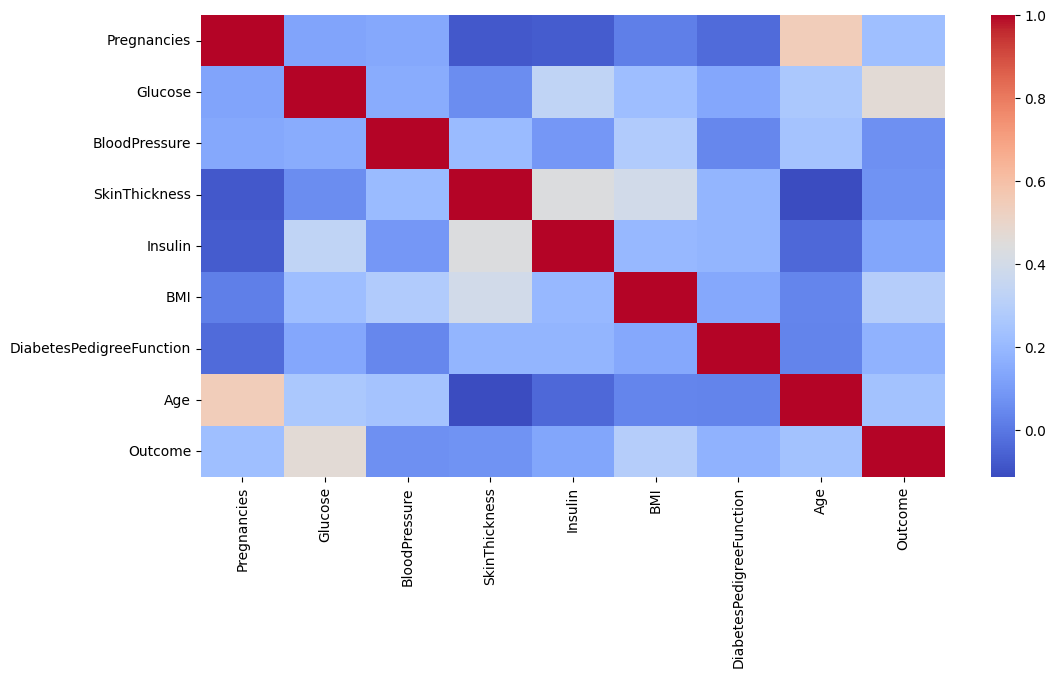

In [13]:
# Plotting correlations between features
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')

## EDA conclusions

- Dataset is small (768 rows), clean, numeric

- Outcome is moderately imbalanced

- Zero values represent missing medical readings

- Features show weak linear correlation → tree models useful

## Preprocessing and model selection

In [70]:
# import necessary libraries
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [61]:
DATA_PATH = "data/pima_data.csv"
MODEL_PATH = "model.bin"

In [64]:
def load_data():
    df = pd.read_csv(DATA_PATH)
    # List of columns where 0 actually means "missing data"
    cols_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

    # change 0 to NaN to calculate the median correctly
    df[cols_to_fix] = df[cols_to_fix].replace(0, np.nan)

    # Fill the NaNs with the median of their respective columns
    df[cols_to_fix] = df[cols_to_fix].fillna(df[cols_to_fix].median())

    y = df['Outcome']
    X = df.drop(columns=['Outcome'])
    return X, y

In [79]:
def train_models(X_train, y_train, X_val, y_val):
    models = {
        "logreg": Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(max_iter=1000))
        ]),
        "rf": RandomForestClassifier(
            n_estimators=300,
            max_depth=7,
            random_state=69
        ),
        "gb": GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.025,
            max_depth=4,
            random_state=69
        ),
        "xgb": XGBClassifier(
            n_estimators=300,
            learning_rate=0.025,
            max_depth=4,
            random_state=69
        )
    }

    scores = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)[:,1]
        scores[name] = roc_auc_score(y_val, preds)

    return models, scores


In [80]:
def main():
    X, y = load_data()

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    models, scores = train_models(X_train, y_train, X_val, y_val)

    best_model_name = max(scores, key=scores.get)
    best_model = models[best_model_name]

    print("Model scores:", scores)
    print("Best model:", best_model_name)

    with open(MODEL_PATH, "wb") as f:
        pickle.dump(best_model, f)

    print("Model saved to", MODEL_PATH)

if __name__ == "__main__":
    main()

Model scores: {'logreg': np.float64(0.812962962962963), 'rf': np.float64(0.8107407407407408), 'gb': np.float64(0.8157407407407408), 'xgb': np.float64(0.8294444444444445)}
Best model: xgb
Model saved to model.bin


## Feature importances

In [81]:
# load the best model
with open('model.bin', 'rb') as f:
    gb_model = pickle.load(f)

/tmp/ipython-input-566652060.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


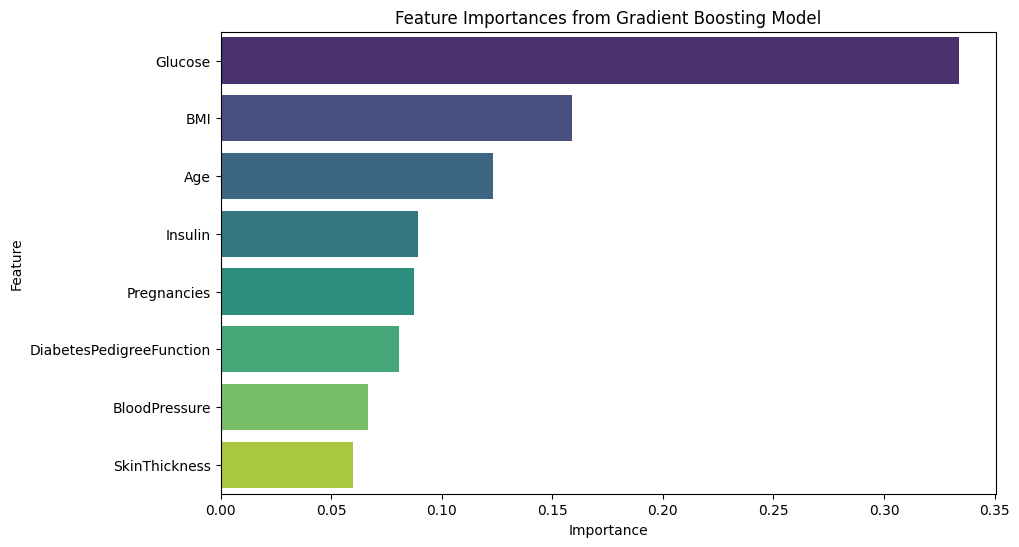

In [82]:
feature_importances = gb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances from Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Note:**
* In both clinical studies and machine learning research, `Glucose` and `BMI` are consistently identified as the top predictors for this specific population.
* **Glucose**: Clinically, diabetes is defined by blood sugar levels. A high value in the Oral Glucose Tolerance Test (the "Glucose" column) is the most direct diagnostic marker.
* **BMI**: Obesity is a primary driver of insulin resistance. In the Pima population, higher BMI is strongly correlated with a higher risk of developing Type 2 diabetes.